## Reproduction

Проведем следующие эксперименты:
 - Logistic regression: повторим результаты на DNA, проведем обучение на mushrooms, добавим в сравнение ```Adagrad```
 - Image classification: приведенные в статье модели достаточно тяжелые, поэтому обучим более простую модель на CIFAR10
 - Natural language processing: повторим результаты на BookWiki, используя GPT Transformer
 - Further experiments: повторим результаты на Criteo Kaggle

# Set-up

## Imports

Импортируем все необходимые библиотеки.

Torch, torchvision, sklearn:

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn.datasets import load_svmlight_file
from torch.utils.data import DataLoader, TensorDataset, random_split

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Системные библиотеки:

In [75]:
import time

from typing import Callable, Iterator

Pyplot, seaborn:

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="Set2")

Tqdm, numpy:

In [77]:
import tqdm
import numpy as np

Сторонние реализации алгоритмов оптимизации:

In [213]:
import dadaptation as dad
import parameterfree as pf
import prodigyopt as pro

## Model pipeline

In [79]:
def train_model(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    **loss_kwargs
) -> None:
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, labels)
        loss.backward(**loss_kwargs)
        optimizer.step()

In [80]:
def eval_model(model: nn.Module, test_loader: DataLoader) -> tuple[float, float]:
    correct = 0
    total = 0
    val_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += torch.sum(predicted == labels).item()
            val_loss += loss_fn(outputs, labels).item()

    return val_loss, correct / total

In [247]:
def check_optimizers(
    optimizers: list[
        tuple[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]]
    ],
    epochs: int,
    model_class: Callable[[], nn.Module],
    train_loader: DataLoader,
    test_loader: DataLoader,
    # lr_decay = (lambda k: 1)
):
    results_dict = {}
    for name, optimizer_lambda in optimizers:
        test_losses = []
        accuracies = []
        time_logs = []
        torch.manual_seed(52)
        model = model_class().to(DEVICE)
        optimizer = optimizer_lambda(model.parameters())

        loss, accuracy = eval_model(model, test_loader)
        test_losses.append(loss)
        accuracies.append(accuracy)

        start_time = time.time()
        with tqdm.tqdm(range(epochs), desc=name) as loop:
            for epoch in loop:
                # decay = lr_decay(epoch)
                # for param_group in optimizer.param_groups:
                #     param_group['lr'] = param_group['lr'] * decay
                train_model(model, optimizer, train_loader, create_graph=True)
                # Подсчет функции потерь и accuracy
                loss, accuracy = eval_model(model, test_loader)
                # Произведите логирование
                test_losses.append(loss)
                accuracies.append(accuracy)
                # torch.cuda.synchronize()

                time_logs.append(time.time() - start_time)
                loop.set_postfix({"Loss": loss, "Accuracy": accuracy})
        results_dict[name] = {
            "Epoch": list(range(epochs + 1)),
            "Time": time_logs,
            "Test Loss": test_losses,
            "Accuracy": accuracies,
        }
    return results_dict

# 1 Logistic regression

In [108]:

optimizers = [("Adam", lambda params: torch.optim.Adam(params)),
              ("Adagrad", lambda params: torch.optim.Adagrad(params)),
              ("D-Adapt Adam", lambda params: dad.DAdaptAdam(params)),
              ("D-Adapt Adagrad", lambda params: dad.DAdaptAdaGrad(params))]

## 1.1 DNA

In [109]:
def GetLoader(
    X: np.ndarray, y: np.ndarray, batch_size: int = 16, shuffle: bool = True
) -> torch.utils.data.dataloader.DataLoader:
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.int64) - 1
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [110]:
train_path = "./Datasets/dna.scale.tr"
test_path = "./Datasets/dna.scale.t"

X_train, y_train = load_svmlight_file(train_path)
X_test, y_test = load_svmlight_file(test_path)

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

train_loader = GetLoader(X_train.toarray(), y_train, batch_size=16, shuffle=False)
test_loader = GetLoader(X_test.toarray(), y_test, batch_size=256, shuffle=False)

class model_class(nn.Sequential):
    def __init__(self):
        super().__init__(torch.nn.Linear(n_features, n_classes))

def lr_decay(k):
    if k ==60:
        return 0.1
    if k ==80:
        return 0.01
    if k ==95:
        return 0.001
    return 1

In [111]:
results = check_optimizers(optimizers, 100, model_class, train_loader, test_loader, lr_decay)

D-Adapt Adagrad: 100%|██████████| 100/100 [00:05<00:00, 17.40it/s, Loss=1.32, Accuracy=0.922]


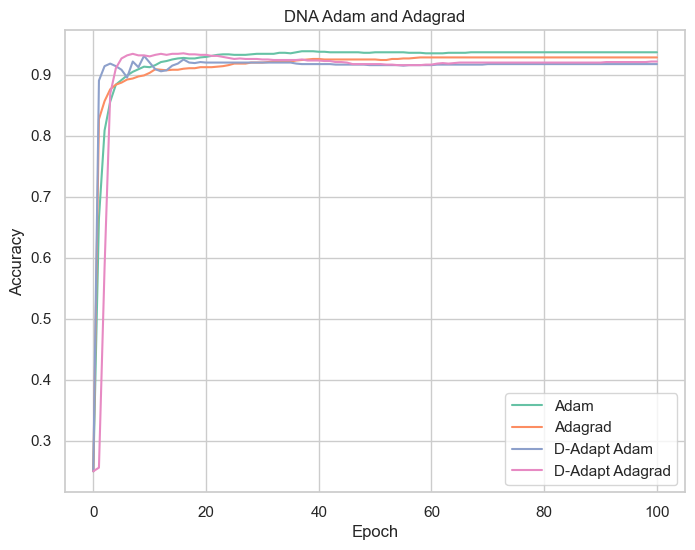

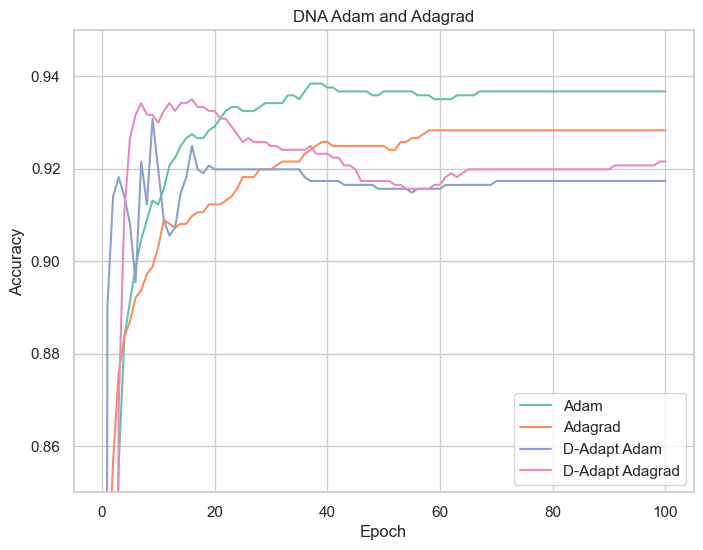

In [112]:
plt.figure(figsize=(8, 6))
for title in results:
    data = results[title]
    plt.plot(data["Accuracy"], label=title)
plt.legend()
plt.title("DNA Adam and Adagrad")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 6))
for title in results:
    data = results[title]
    plt.plot(data["Accuracy"], label=title)
plt.legend()
plt.ylim(0.85, 0.95)
plt.title("DNA Adam and Adagrad")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## 1.2 mushrooms

In [113]:
path = "./Datasets/mushrooms.txt"
data = load_svmlight_file(path)
X, y = data[0].toarray(), data[1]
y = y - 1
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.int64))
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(52))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

n_features = X.shape[1]
n_classes = len(np.unique(y))

class model_class(nn.Sequential):
    def __init__(self):
        super().__init__(torch.nn.Linear(n_features, n_classes))

In [114]:
results = check_optimizers(optimizers, 25, model_class, train_loader, test_loader, lr_decay)

D-Adapt Adagrad: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s, Loss=0.00304, Accuracy=1]  


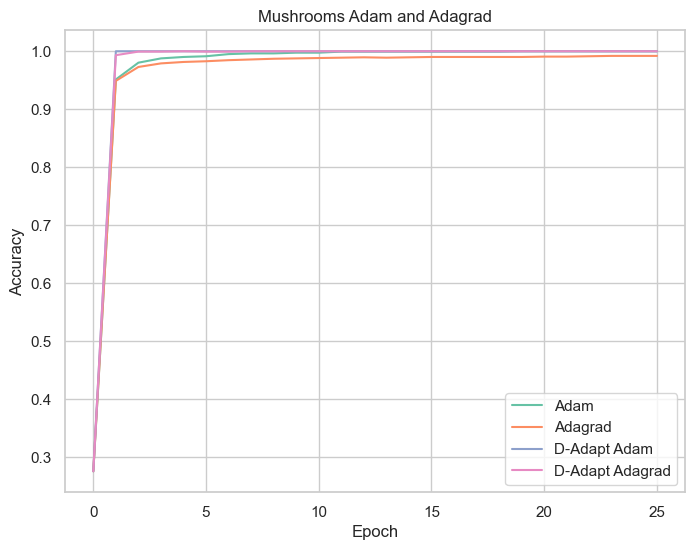

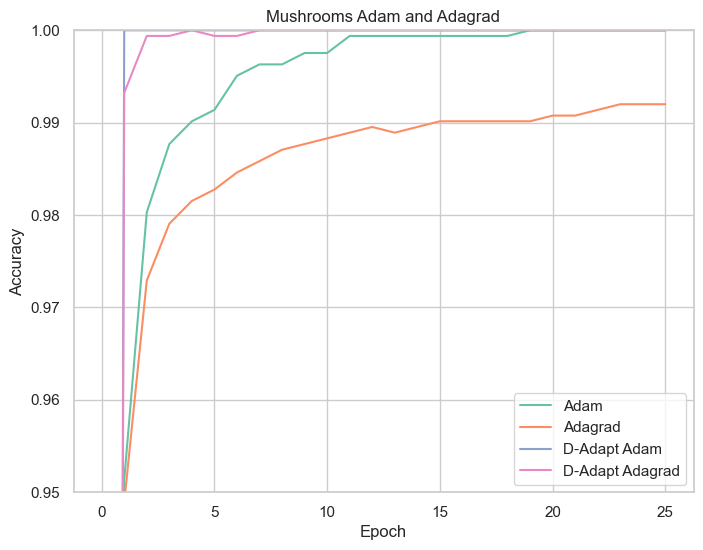

In [115]:
plt.figure(figsize=(8, 6))
for title in results:
    data = results[title]
    plt.plot(data["Accuracy"], label=title)
plt.legend()
plt.title("Mushrooms Adam and Adagrad")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 6))
for title in results:
    data = results[title]
    plt.plot(data["Accuracy"], label=title)
plt.legend()
plt.ylim(0.95, 1)
plt.title("Mushrooms Adam and Adagrad")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# 2 Image classification

In [257]:
optimizers = [
    ("SGD", lambda params: torch.optim.SGD(params, lr=0.01, weight_decay=0.001)),
    ("D-Adapt SGD", lambda params: dad.DAdaptSGD(params, lr=0.1, growth_rate=1.005)),
    ("D-Adapt Adam", lambda params: dad.DAdaptAdam(params, growth_rate=1.005)),
    ("COCOB", lambda params: pf.COCOB(params)),
    ("Prodigy", lambda params: pro.Prodigy(params, growth_rate=1.001)),
]

In [258]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
train_dataset = torchvision.datasets.CIFAR10(
    root="./Datasets", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./Datasets", train=False, download=True, transform=transform
)
ratio = 0.5
# делим данные train и test
train_dataset, _ = random_split(
    train_dataset,
    [ratio, 1 - ratio],
    generator=torch.Generator().manual_seed(420),
)
test_dataset, _ = random_split(
    test_dataset,
    [ratio, 1 - ratio],
    generator=torch.Generator().manual_seed(420),
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [259]:
class CifarNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [260]:
results = check_optimizers(optimizers, 25, CifarNet, train_loader, test_loader)

Prodigy: 100%|██████████| 25/25 [03:13<00:00,  7.74s/it, Loss=34.4, Accuracy=0.38] 


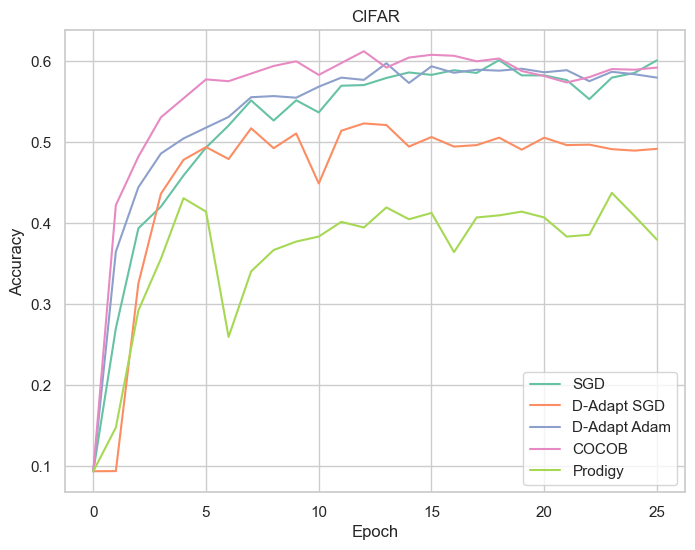

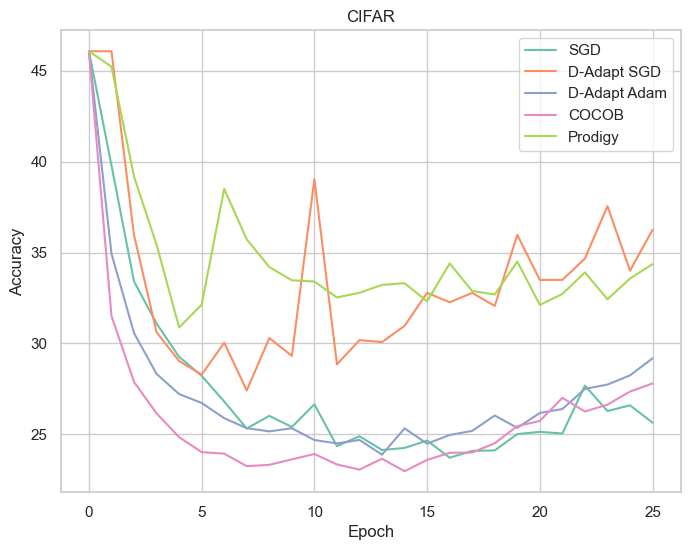

In [266]:
plt.figure(figsize=(8, 6))
for title in results:
    data = results[title]
    plt.plot(data["Accuracy"], label=title)
plt.legend()
plt.title("CIFAR")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 6))
for title in results:
    data = results[title]
    plt.plot(data["Test Loss"], label=title)
plt.legend()
plt.title("CIFAR")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# 3 Natural language processing

# 4 Recommendation system